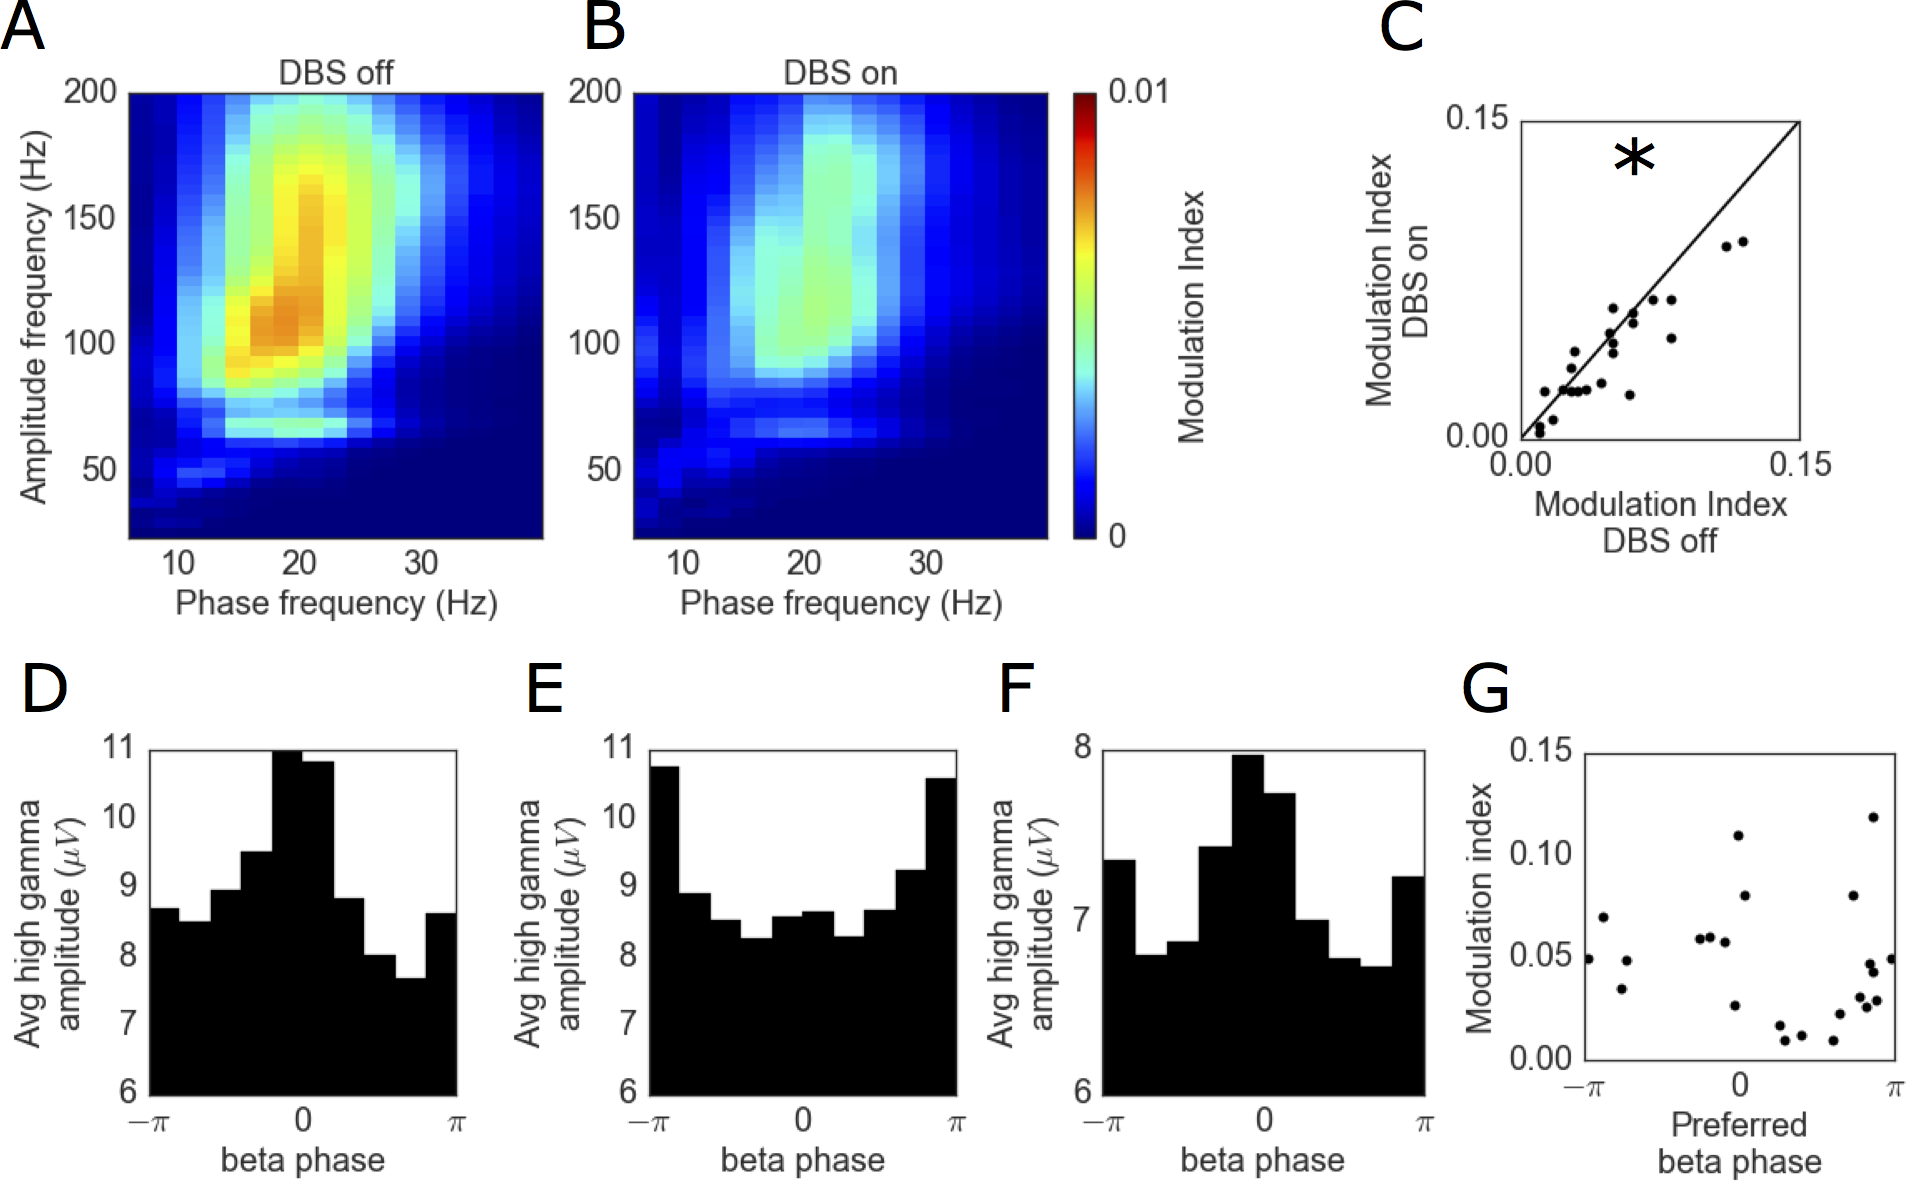

In [1]:
from IPython.display import Image
Image(filename = "./img/fig3.png", width=600)

# Figure 3
Estimates of phase-amplitude coupling in PD. A, Comodulogram showing estimated beta-high gamma PAC in an example PD patient before DBS. B, The estimated PAC decreases with
DBS application. C, Estimated PAC decreases with DBS application. D–F, Distributions of high gamma amplitude as a function of beta phase for 3 example PD patients before DBS showing increased
high gamma amplitude at (D) the peak of the beta oscillation, (E) trough of the beta oscillation, and (F) both extrema of the beta oscillation. G, High estimated PAC is observed specifically in
recordings in which the high gamma amplitude is increased around the peak (phase=0) or trough (phase=-$\pi$,$\pi$) C, G, Each dot indicates 1 patient. *p=0.05.

**Imports**

In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('white')

In [3]:
import util

**Load data**

In [4]:
ecog = util.loadPD()
Fs, t, S, Sdy, flo, fhi = util.loadmeta()

**Shape Calculations**

In [5]:
widthS = 5 # hyperparameter for calculating sharpness

pks, trs, pksharp, trsharp, esrs, \
peaktotrough, risteep, desteep, rdsrs, \
risetodecay = util.measure_shape(ecog, widthS=widthS)

**PAC calculation**

In [6]:
pac = util.measure_pac(ecog, flo, fhi, Fs=Fs)

# A
### Phase-amplitude coupling comodulogram in example subject before DBS

In [7]:
from pac import comodulogram
from matplotlib import cm

# Parameters
s = 0
sdy = 0
fp = (6,40)
fa = (20,200)
dp = 2
da = 4
pac_method = 'mi_tort'
w=7

f_phases = np.arange(fp[0], fp[1]+dp, dp)
f_amps = np.arange(fa[0], fa[1]+da, da)

# Calculate PAC comodulogram
comodB = comodulogram(ecog['B'][s], ecog['B'][s], fp, fa, dp, da,
                            fs=Fs, pac_method=pac_method, w=w)

comodD = comodulogram(ecog['D'][s], ecog['D'][s], fp, fa, dp, da,
                            fs=Fs, pac_method=pac_method, w=w)

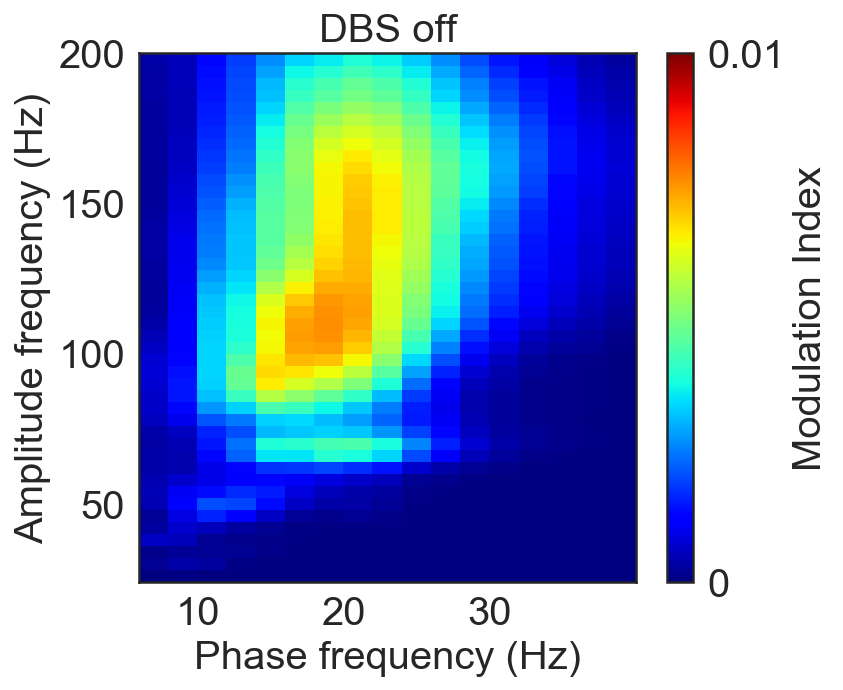

In [8]:
clim = [0,.01]

plt.figure(figsize=(6,5))
cax = plt.pcolor(f_phases, f_amps+da, comodB.T, cmap=cm.jet, vmin=clim[0], vmax=clim[1])
cbar = plt.colorbar(cax, ticks=clim)
cbar.ax.set_yticklabels(clim,size=20)
cbar.ax.set_ylabel('Modulation Index', size=20)
plt.title('DBS off', size=20)
plt.axis([f_phases[0], f_phases[-1], f_amps[0]+da, f_amps[-1]])
plt.xlabel('Phase frequency (Hz)', size=20)
plt.ylabel('Amplitude frequency (Hz)', size=20)
plt.yticks(np.arange(50,250,50),size=20)
plt.xticks(np.arange(10,40,10),size=20)
plt.tight_layout()

# B
### Phase-amplitude coupling comodulogram in example subject during DBS

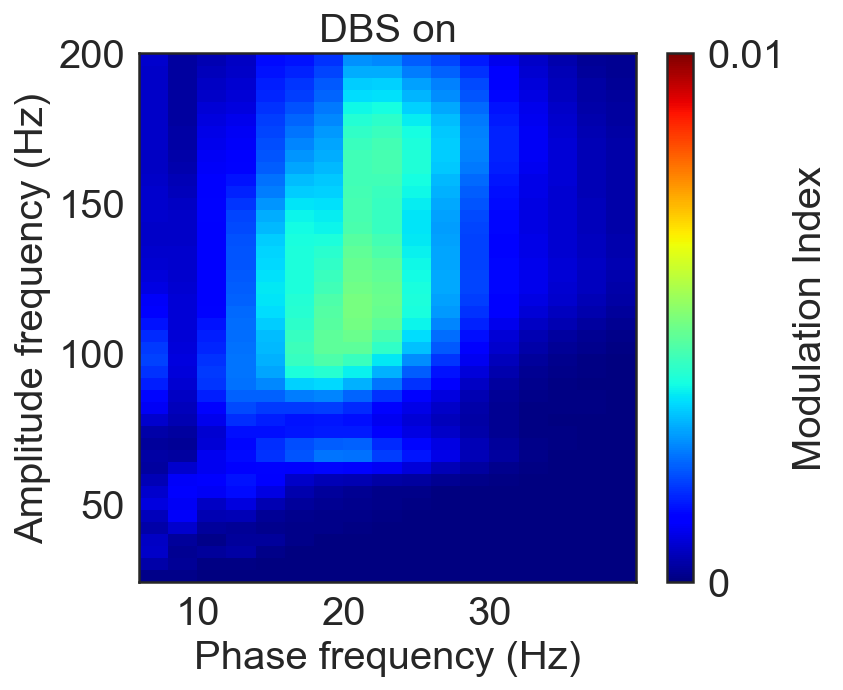

In [9]:
plt.figure(figsize=(6,5))
cax = plt.pcolor(f_phases, f_amps+da, comodD.T, cmap=cm.jet, vmin=clim[0], vmax=clim[1])
cbar = plt.colorbar(cax, ticks=clim)
cbar.ax.set_yticklabels(clim,size=20)
cbar.ax.set_ylabel('Modulation Index', size=20)
plt.title('DBS on', size=20)
plt.axis([f_phases[0], f_phases[-1], f_amps[0]+da, f_amps[-1]])
plt.xlabel('Phase frequency (Hz)', size=20)
plt.ylabel('Amplitude frequency (Hz)', size=20)
plt.yticks(np.arange(50,250,50),size=20)
plt.xticks(np.arange(10,40,10),size=20)
plt.tight_layout()

# C
### Decrease in PAC with DBS

Ttest_relResult(statistic=2.6944195077370745, pvalue=0.013243356877584361)


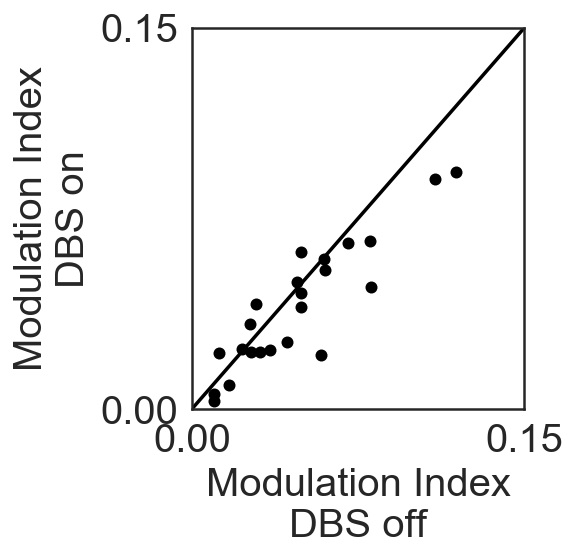

In [10]:
# DBS decreases PAC
from plt import scatt_2cond
scatt_2cond(pac['B'],pac['D'],ms=12,
           lims = (0,.15), xlabel = 'Modulation Index\nDBS off',
            ylabel = 'Modulation Index\nDBS on',figsize=(4,4))
plt.tick_params(labelsize=20)

print(sp.stats.ttest_rel(pac['B'],pac['D']))

# D-F
### Example phase-amplitude coupling histograms for 3 subjects before DBS

In [11]:
# Calculate Hilbert-based beta phase and HFA amplitude over time
from pac import pa_series
BphaHB = np.zeros(S,dtype=object)
HFAampB = np.zeros(S,dtype=object)
BphaHD = np.zeros(S,dtype=object)
HFAampD = np.zeros(S,dtype=object)
filter_kwargslo={'Ntaps':231}
filter_kwargshi={'Ntaps':240}
for s in range(S):
    BphaHB[s], HFAampB[s] = pa_series(ecog['B'][s],ecog['B'][s],flo,fhi,filter_kwargslo=filter_kwargslo,filter_kwargshi=filter_kwargshi)
    BphaHD[s], HFAampD[s] = pa_series(ecog['D'][s],ecog['D'][s],flo,fhi,filter_kwargslo=filter_kwargslo,filter_kwargshi=filter_kwargshi)

In [12]:
# Calculate waveform-based beta phase
from shape import wfpha
from pac import _trim_edges
    
BphaWB = np.zeros(S,dtype=object)
BphaWD = np.zeros(S,dtype=object)
for s in range(S):
    BphaWB[s] = wfpha(ecog['B'][s], pks['B'][s], trs['B'][s])
    BphaWB[s], _ = _trim_edges(BphaWB[s],HFAampB[s])
    
    BphaWD[s] = wfpha(ecog['D'][s], pks['D'][s], trs['D'][s])
    BphaWD[s], _ = _trim_edges(BphaWD[s],HFAampD[s])

In [13]:
# Calculate PAC distributions
from pac import pa_dist
Nbins = 10
padistB = np.zeros((S,int(Nbins)))
padistD = np.zeros((S,int(Nbins)))
for s in range(S):
    phase_bins, padistB[s] = pa_dist(BphaWB[s],HFAampB[s],Nbins)
    _, padistD[s] = pa_dist(BphaWD[s],HFAampD[s],Nbins)

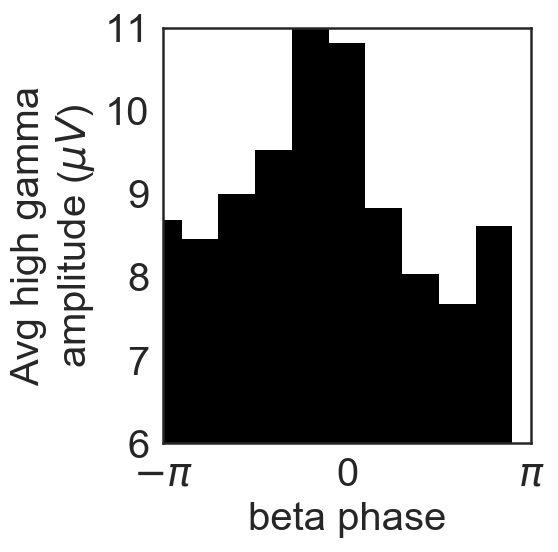

In [14]:
# Plot histograms for 3 subjects (12: peak, 2: both, 4: trough)
s1 = 12
s2 = 4
s3 = 2

plt.figure(figsize=(4,4))
plt.bar(phase_bins,padistB[s1],phase_bins[1]-phase_bins[0],color='k')
plt.xlim((-np.pi,np.pi))
plt.xticks(np.arange(-np.pi,np.pi*1.1,np.pi),['$-\pi$',0,'$\pi$'],size=20)
plt.xlabel('beta phase',size=20)
plt.ylabel('Avg high gamma\namplitude ($\mu V$)',size=20)
plt.yticks(size=15)
plt.ylim((6,11))
plt.tight_layout()
plt.tick_params(labelsize=20)

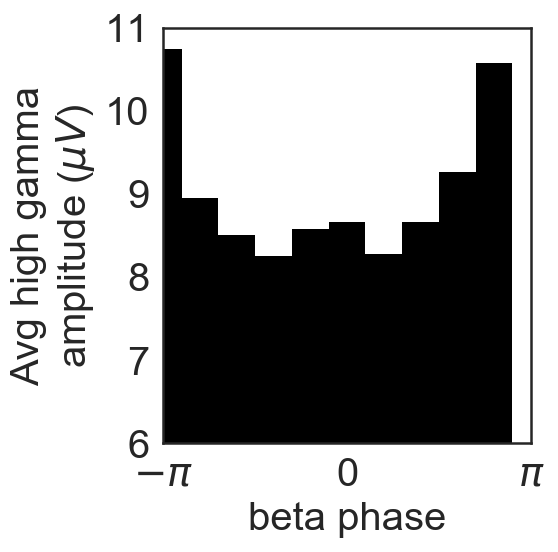

In [15]:
plt.figure(figsize=(4,4))
plt.bar(phase_bins,padistB[s2],phase_bins[1]-phase_bins[0],color='k')
plt.xlim((-np.pi,np.pi))
plt.xticks(np.arange(-np.pi,np.pi*1.1,np.pi),['$-\pi$',0,'$\pi$'],size=20)
plt.xlabel('beta phase',size=20)
plt.ylabel('Avg high gamma\namplitude ($\mu V$)',size=20)
plt.yticks(size=15)
plt.ylim((6,11))
plt.tight_layout()
plt.tick_params(labelsize=20)

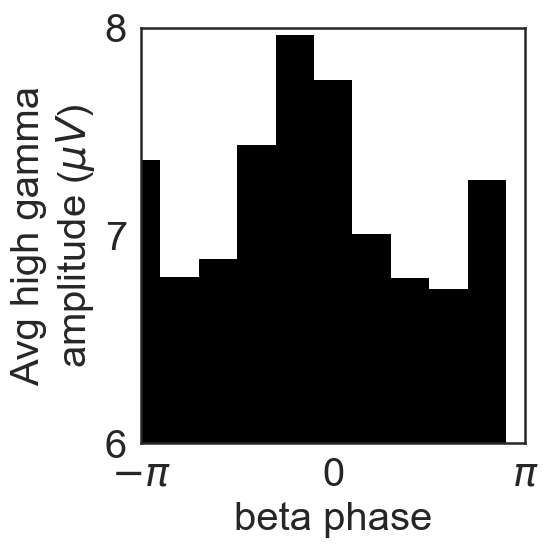

In [16]:
plt.figure(figsize=(4,4))
plt.bar(phase_bins,padistB[s3],phase_bins[1]-phase_bins[0],color='k')
plt.xlim((-np.pi,np.pi))
plt.xticks(np.arange(-np.pi,np.pi*1.1,np.pi),['$-\pi$',0,'$\pi$'],size=20)
plt.xlabel('beta phase',size=20)
plt.ylabel('Avg high gamma\namplitude ($\mu V$)',size=20)
plt.yticks((6,7,8),size=15)
plt.ylim((6,8))
plt.tight_layout()
plt.tick_params(labelsize=20)

# G
### Across subjects, strongest PAC occurs at the extrema

In [17]:
# Calculate preferred phase for each subjects
def calcprefpha(x,pks, trs, fhi=(50,200), w_hi=12, Fs= 1000.):
    from pac import firf, _trim_edges
    betapha = wfpha(x, pks, trs)
    hg = firf(x, fhi, fs=Fs, Ntaps=240)
    hgamp = np.abs(sp.signal.hilbert(hg))
    
    betapha, hgamp = _trim_edges(betapha,hgamp)
    cplx = hgamp * np.exp(1j*betapha)
    prefpha = np.angle(np.sum(cplx))
    return prefpha
    
prefpha = np.zeros(S)
for s in range(S):
    prefpha[s] = calcprefpha(ecog['B'][s],pks['B'][s],trs['B'][s])

SpearmanrResult(correlation=0.5810276679841897, pvalue=0.0036444270201514803)


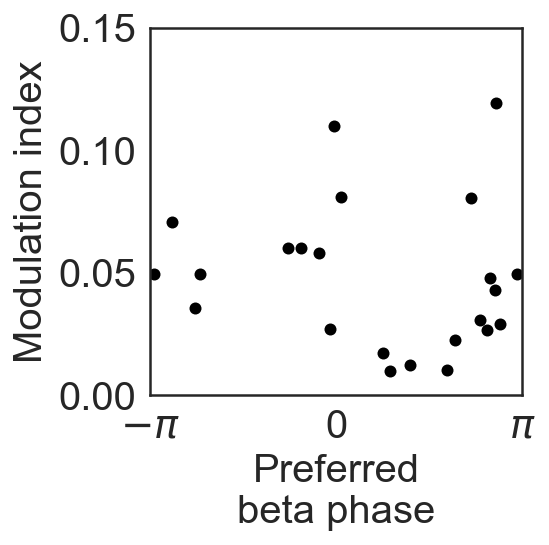

In [18]:
plt.figure(figsize=(4,4))
plt.plot(prefpha,pac['B'],'k.',ms=12)
plt.xlim((-np.pi,np.pi))
plt.ylim((0,.15))
plt.xticks((-np.pi,0,np.pi),('$-\pi$','0','$\pi$'),size=20)
plt.yticks(np.arange(0,.2,.05),size=20)
plt.xlabel('Preferred\nbeta phase',size=20)
plt.ylabel('Modulation index',size=20)
plt.tight_layout()

abscos = abs(np.cos(prefpha))
print(sp.stats.spearmanr(abscos,pac['B']))